# Machine Learning

## Import Libraries

In [ ]:
# First, you need to install and import the necessary libraries

!pip install pythainlp
!pip install sklearn_crfsuite
!pip install fastai
!pip install statistics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 49.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 10.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7453 sha256=8788d489a99b47684e4241ceac3447c744c7670b16177614e5742a991445b503
  Stored in directory: /root/.cache/pip/wheels/59/bd/aa/41ad56fbb723d36e457b5be74feb992cdac2855a6999ba34a1
Successfully built statistics


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

import statistics
import joblib
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.util import normalize
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Import Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/byinth/LimeSoda/main/dataset_train_wo_tokentags_v1/raw/data_notagword_v1.csv')

In [ ]:
df.head()

,text,tags
0,"['พี่', 'สาว', 'คน', 'ข้าง', 'บ้าน', 'เป็น', '...",Fake News
1,"['กิน', 'แทน', 'ข้าว', 'หนุ่ม', 'เวียดนาม', 'ป...",Fake News
2,"['ผง', 'ชูรส', 'นี่', 'ก็', 'สาร', 'พิษ', 'ก่อ...",Fake News
3,"['รู้', 'ไว้', 'มี', 'ประโยชน์', '!', '', '', ...",Fake News
4,"['มะหวด', '', '', '(', 'หมากหวด', 'ข่า', ')', ...",Fake News


## Data Understanding

เนื่องจาก Dataset ที่ได้มาค่อนข้างที่จะสมบูรณ์ และขนาดของตัวอย่างก็มีจำนวนใกล้เคียงกัน ดังนั้นจึงจะไม่เกิดปัญหา Model bias และไม่ได้แก้ปัญหาเรื่อง Imbalance Dataset

<Axes: >

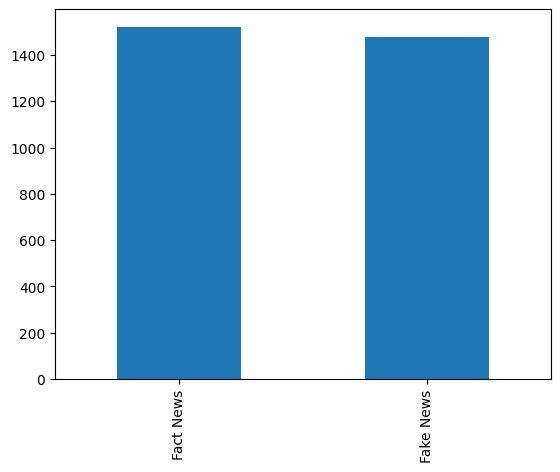

In [ ]:
df['tags'].value_counts().plot.bar()

In [ ]:
#Percentage of Positive/Negative
print("Fake News: ", df.tags.value_counts()[0]/len(df['tags'])*100,"%")
print("Fact News: ", df.tags.value_counts()[1]/len(df['tags'])*100,"%")

Fake News:  50.73382254836558 %
Fact News:  49.26617745163443 %


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2998 non-null   object
 1   tags    2998 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [ ]:
len(df)

2998

## Data Preparation

In [ ]:
from pythainlp.corpus.common import thai_stopwords
import re
import nltk
from pythainlp.util import normalize

In [ ]:
# Preprocess the data

def preprocess_text(text):
    # Remove non-Thai characters and digits
    text = re.sub(r'[^\u0E00-\u0E7F\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = normalize(text) # normalize the text
    # Tokenize text
    words = nltk.word_tokenize(text.lower())
    # Remove stop words
    words = [word for word in words if not word in thai_stopwords()]
    # Join words back into text
    return ' '.join(words)

df['text'] = df['text'].apply(preprocess_text)

In [ ]:
# !pip install WordCloud
# from wordcloud import WordCloud, STOPWORDS
# df_fact = df[df['tags'] == 'Fact News']
# pos_word_all = " ".join(text for text in df_fact['text'])
# reg = r"[ก-๙a-zA-Z']+"
# wordcloud = WordCloud(stopwords=thai_stopwords, background_color = 'white', max_words=2000, height = 2000, width=4000, regexp=reg).generate(pos_word_all)
# plt.figure(figsize = (16,8))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

In [ ]:
#df_fake = df[df['tags'] == 'Fake News']
#neg_word_all = " ".join(text for text in df_fake['text'])
#wordcloud = WordCloud(stopwords=thai_stopwords, background_color = 'white', max_words=2000, height = 2000, width=4000, font_path=fp, regexp=reg).generate(neg_word_all)
#plt.figure(figsize = (16,8))
#plt.imshow(wordcloud)
#plt.axis('off')
#plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['tags'], test_size=0.2, random_state=42)

In [ ]:
# # Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(smooth_idf=True,use_idf=True)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Modeling

### Linear SVC

In [ ]:
# Train a Linear Support Vector Classifier (SVM) model
lsvc_model = LinearSVC()
lsvc_model.fit(X_train, y_train)

LinearSVC()

In [ ]:
# Evaluate the model on the testing set
lsvc_y_pred = lsvc_model.predict(X_test)
lsvc_accuracy = accuracy_score(y_test, lsvc_y_pred)
print(f"Accuracy: {lsvc_accuracy}")
print(classification_report(y_test, lsvc_y_pred))

Accuracy: 0.87
              precision    recall  f1-score   support

   Fact News       0.84      0.90      0.87       289
   Fake News       0.90      0.84      0.87       311

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



In [ ]:
# ทดสอบให้ Model ทำนายเนื้อข่าวและเปรียบเทียบกับผลลัพธ์จริง
testnews = df['text'][20]
testResult = df['tags'][20]
news = vectorizer.transform([testnews])

svc_prediction = lsvc_model.predict(news)
print('SVC Prediction tag is:', svc_prediction, ' Actual tag is: ', testResult)

SVC Prediction tag is: ['Fake News']  Actual tag is:  Fake News


### Logistic Regression

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
lr_y_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_y_pred)
print('Accuracy:', lr_accuracy)
print(classification_report(y_test, lr_y_pred))

Accuracy: 0.8866666666666667
              precision    recall  f1-score   support

   Fact News       0.86      0.92      0.89       289
   Fake News       0.92      0.86      0.89       311

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600



### SVM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


svm_model = SVC(kernel="linear", C=1)
svm_model.fit(X_train, y_train)

SVC(C=1, kernel='linear')

In [ ]:
scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print("Cross-validation scores:", scores)

Cross-validation scores: [0.87083333 0.89375    0.8875     0.86430063 0.88726514]


In [ ]:
# Evaluate the performance of the trained SVM classifier on the testing set
svm_y_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_y_pred);
print("Accuracy:", svm_accuracy)
print("Precision:", precision_score(y_test, svm_y_pred, average="macro"))
print("Recall:", recall_score(y_test, svm_y_pred, average="macro"))
print("F1-score:", f1_score(y_test, svm_y_pred, average="macro"))
print(classification_report(y_test, svm_y_pred))

Accuracy: 0.88
Precision: 0.8806350123956377
Recall: 0.880939930350805
F1-score: 0.8799946664296191
              precision    recall  f1-score   support

   Fact News       0.85      0.91      0.88       289
   Fake News       0.91      0.86      0.88       311

    accuracy                           0.88       600
   macro avg       0.88      0.88      0.88       600
weighted avg       0.88      0.88      0.88       600



In [ ]:
def listToString(s):
    # initialize an empty string
    str1 = " "
    # return string 
    return (str1.join(s))

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train, y_train)
knn_y_pred = knn_model.predict(X_test)

In [ ]:
knn_accuracy = knn_model.score(X_test, y_test);
print('ค่าความถูกต้องของ Model : KNN อยู่ที่ : ', knn_accuracy);

ค่าความถูกต้องของ Model : KNN อยู่ที่ :  0.8333333333333334


In [ ]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

   Fact News       0.79      0.88      0.83       289
   Fake News       0.87      0.78      0.83       311

    accuracy                           0.83       600
   macro avg       0.83      0.83      0.83       600
weighted avg       0.83      0.83      0.83       600



### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_model = DecisionTreeClassifier(random_state=10)

# Train model
# your code here
dt_model.fit(X_train, y_train)

# Predict named 'dt_y_pred'
# your code here
dt_y_pred = dt_model.predict(X_test)

In [ ]:
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print('ค่าความถูกต้องของ Model : Decission Tree อยู่ที่ : ', dt_accuracy);

ค่าความถูกต้องของ Model : Decission Tree อยู่ที่ :  0.805


In [ ]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

   Fact News       0.79      0.81      0.80       289
   Fake News       0.82      0.80      0.81       311

    accuracy                           0.81       600
   macro avg       0.80      0.81      0.80       600
weighted avg       0.81      0.81      0.81       600



### Convolutional Neural Network

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
nn_df = pd.read_csv('https://raw.githubusercontent.com/byinth/LimeSoda/main/dataset_train_wo_tokentags_v1/raw/data_notagword_v1.csv')

In [ ]:
# Tokenize the text data
nn_tokenizer = Tokenizer()
nn_tokenizer.fit_on_texts(nn_df['text'])
nn_sequences = nn_tokenizer.texts_to_sequences(nn_df['text'])
nn_word_index = nn_tokenizer.word_index
nn_max_len = 100
nn_data = pad_sequences(nn_sequences, maxlen=nn_max_len)

In [ ]:
# Convert the tags into numerical vectors
nn_tags = pd.get_dummies(nn_df['tags']).values

In [ ]:
# Split the dataset into training, validation, and test sets
nn_train_data, nn_test_data, nn_train_tags, nn_test_tags = train_test_split(nn_data, nn_tags, test_size=0.2)
nn_train_data, nn_val_data, nn_train_tags, nn_val_tags = train_test_split(nn_train_data, nn_train_tags, test_size=0.2)

In [ ]:
# Define the CNN model architecture
nn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(nn_word_index)+1, 100, input_length=nn_max_len),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(16, activation='softmax'),
    tf.keras.layers.Dense(2, activation='sigmoid')
])

# Compile the model
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']);

# Train the model
nn_model.fit(nn_train_data, nn_train_tags, epochs=20, batch_size=128, validation_data=(nn_val_data, nn_val_tags))

# Evaluate the model on the test set
loss, cnn_accuracy = nn_model.evaluate(nn_test_data, nn_test_tags, batch_size=128);
print('Test Accuracy:', cnn_accuracy)

Epoch 1/20
15/15 [==============================] - 3s 146ms/step - loss: 0.6940 - accuracy: 0.4948 - val_loss: 0.6920 - val_accuracy: 0.5208
Epoch 2/20
15/15 [==============================] - 2s 123ms/step - loss: 0.6902 - accuracy: 0.5146 - val_loss: 0.6876 - val_accuracy: 0.5042
Epoch 3/20
15/15 [==============================] - 2s 125ms/step - loss: 0.6788 - accuracy: 0.6303 - val_loss: 0.6645 - val_accuracy: 0.7396
Epoch 4/20
15/15 [==============================] - 2s 127ms/step - loss: 0.6343 - accuracy: 0.7925 - val_loss: 0.6012 - val_accuracy: 0.7958
Epoch 5/20
15/15 [==============================] - 4s 274ms/step - loss: 0.5447 - accuracy: 0.8629 - val_loss: 0.5287 - val_accuracy: 0.8292
Epoch 6/20
15/15 [==============================] - 3s 184ms/step - loss: 0.4519 - accuracy: 0.9155 - val_loss: 0.4760 - val_accuracy: 0.8583
Epoch 7/20
15/15 [==============================] - 2s 122ms/step - loss: 0.3772 - accuracy: 0.9567 - val_loss: 0.4438 - val_accuracy: 0.8604
Epoch 

In [ ]:
cnn_accuracy

0.8733333349227905

## Evaluation

### เปรียบเทียบ Confusion Metrix ของแต่ละ Model

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

In [ ]:
classifiers = {
    "Linear SVC": lsvc_model,
    "LogisiticRegression": lr_model,
    "Support Vector Machine": svm_model,
    "KNearest": knn_model,
    "DecisionTreeClassifier": dt_model
}


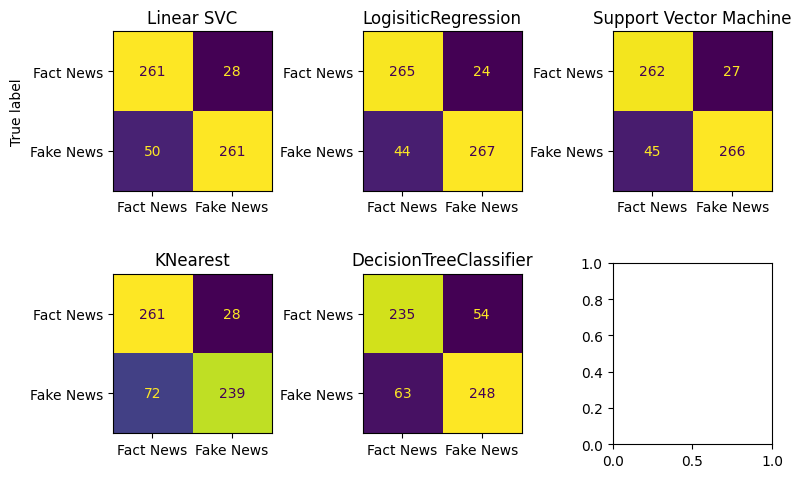

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,5))

idx = 0;
for i,(key, cls) in enumerate(classifiers.items()):
  j = i%3;
  if((i%3 == 0) & (i > 0)):
    idx = idx+1;

  y_predicted = cls.predict(X_test)
  cm = confusion_matrix(y_test, y_predicted, labels=cls.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=cls.classes_)
  disp.plot(ax=axes[idx,j])
  disp.ax_.set_title(key)
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel('')
  if i!=0:
    disp.ax_.set_ylabel('')
plt.tight_layout()  
plt.show()


### เปรียบเทียบความแม่นยำของแต่ละ Model

<ipython-input-197-9e3a594a041d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfacc = dfacc.append(dfacc2, ignore_index = True)
<ipython-input-197-9e3a594a041d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfacc = dfacc.append(dfacc2, ignore_index = True)
<ipython-input-197-9e3a594a041d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfacc = dfacc.append(dfacc2, ignore_index = True)
<ipython-input-197-9e3a594a041d>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfacc = dfacc.append(dfacc2, ignore_index = True)
<ipython-input-197-9e3a594a041d>:13: FutureWarning: The frame.append method is deprecated and will be removed fr

Text(0.5, 1.0, 'Models Accuracy')

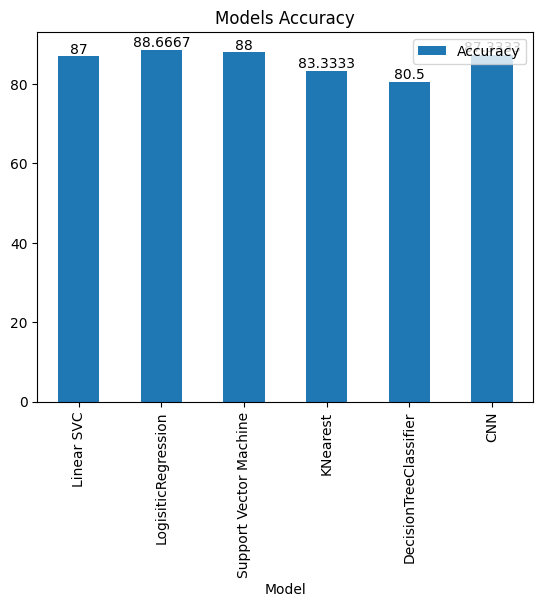

In [ ]:
accuracies = {
    "Linear SVC": lsvc_accuracy,
    "LogisiticRegression": lr_accuracy,
    "Support Vector Machine": svm_accuracy,
    "KNearest": knn_accuracy,
    "DecisionTreeClassifier": dt_accuracy,
    "CNN": cnn_accuracy
}

dfacc = pd.DataFrame()
for i,(key, acc) in enumerate(accuracies.items()):
  dfacc2 = {'Model': key, 'Accuracy':acc*100}
  dfacc = dfacc.append(dfacc2, ignore_index = True)
  
# plotting a bar graph
ax = dfacc.plot(x="Model", y="Accuracy", kind="bar")

for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Models Accuracy')

**เรียงลำดับตามความแม่นยำของ Model**

In [ ]:
dfacc.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy
1,LogisiticRegression,88.666667
2,Support Vector Machine,88.000000
5,CNN,87.333333
0,Linear SVC,87.000000
3,KNearest,83.333333
4,DecisionTreeClassifier,80.500000


# Voting Model

**ทำ Majority Vote เพื่อเลือกผลลัพท์ที่ Model ทำนายออกมาเหมือนกันมากที่สุด**

In [ ]:
voting_df = pd.DataFrame({'svc':lsvc_y_pred,
                          'lr':lr_y_pred,
                          'svm':svm_y_pred,  
                          'knn':knn_y_pred,
                          'dt':dt_y_pred})
voting_df.head()

,svc,lr,svm,knn,dt
0,Fact News,Fact News,Fact News,Fact News,Fake News
1,Fact News,Fact News,Fake News,Fact News,Fact News
2,Fake News,Fake News,Fake News,Fact News,Fact News
3,Fact News,Fact News,Fact News,Fact News,Fact News
4,Fake News,Fake News,Fake News,Fake News,Fake News


In [ ]:
#Vote จากการทำนายว่าเป็น Fact News โดยการแปลงค่า Categorical เป็น binary ก่อน เพื่อง่ายต่อการหาผลลัพธ์
voting_df_binary = voting_df.replace('Fact News', 1)
voting_df_binary = voting_df_binary.replace('Fake News', 0)
voting_df_binary.head()

,svc,lr,svm,knn,dt
0,1,1,1,1,0
1,1,1,0,1,1
2,0,0,0,1,1
3,1,1,1,1,1
4,0,0,0,0,0


**หาผลรวมการทำนายของทุก model**

In [ ]:
# สร้างผลลัพธ์โดยกำหนดว่าถ้าผลรวมการทำนาย >= 3 ให้ทำนายเป็น Fact news โดยกำหนดให้ Fact news มีค่าเป็น 1 ถ้าไม่ใช่ให้เป็น = 0
voting_df_binary = voting_df_binary.sum(axis=1)
result = voting_df_binary.apply(lambda x:1 if x>=3 else 0)

In [ ]:
print('Result:')
print('ผลทำนายที่เป็น Fake News มากกว่า 3 Models มีจำนวน = ', (result == 0).sum())
print('ผลทำนายที่เป็น Fact News มากกว่า 3 Models มีจำนวน = ', (result == 1).sum())
print()

Result:
ผลทำนายที่เป็น Fake News มากกว่า 3 Models มีจำนวน =  288
ผลทำนายที่เป็น Fact News มากกว่า 3 Models มีจำนวน =  312



# Test All Models

In [ ]:
test_article = input('Enter your news: ')
print()

#ML - SVC
lsvc_test_article_vectorized = vectorizer.transform([test_article])
lsvc_prediction = lsvc_model.predict(lsvc_test_article_vectorized)
print('LSVC Prediction tag is:', lsvc_prediction)

#ML - Linear Regression
lr_test_article_vectorized = vectorizer.transform([test_article])
lr_prediction = lr_model.predict(lr_test_article_vectorized)
print('LR Prediction tag is:', lr_prediction)

# ML - SVM
svm_test_article_vectorized = vectorizer.transform([test_article])
svm_prediction = svm_model.predict(svm_test_article_vectorized)
print('SVM Prediction tag is:', svm_prediction)

#ML - KNN
knn_test_article_vectorized = vectorizer.transform([test_article])
knn_prediction = knn_model.predict(knn_test_article_vectorized)
print('KNN Prediction tag is:', knn_prediction)

#ML - Decision Tree
dt_test_article_vectorized = vectorizer.transform([test_article])
dt_prediction = dt_model.predict(dt_test_article_vectorized)
print('Decision Tree Prediction tag is:', dt_prediction)

#CNN
nn_test_article_sequence = nn_tokenizer.texts_to_sequences([test_article]);
nn_test_article_padded = pad_sequences(nn_test_article_sequence, maxlen=nn_max_len);
nn_prediction = nn_model.predict(nn_test_article_padded);
nn_prediction_str = ''

#Matrix[FakeNews, FactName]
if nn_prediction[0][0] > nn_prediction[0][1]:
    nn_prediction_str = 'Fact News'
else:
    nn_prediction_str = 'Fake News'
print()
print('CNN Prediction tag is:', nn_prediction_str)

ls = []
#Arrays.asList(array)
ls.append(listToString(lsvc_prediction))
ls.append(listToString(lr_prediction))
ls.append(listToString(svm_prediction))
ls.append(listToString(knn_prediction))
ls.append(listToString(dt_prediction))
ls.append(nn_prediction_str)

print()
classification = statistics.mode(ls);
print("ผลการทำนายจาก Models จำนวน ", len(ls) ," models คือ ['",classification,"']")
print()
print("โดยมีค่าเฉลียของการเป็น ",classification," อยู่ที่: ", (ls.count(classification) * 100) / len(ls) , '%')


Enter your news: พลเอกประยุทธเป็นนายกรัฐมนตรีสมัยที่ 3

LSVC Prediction tag is: ['Fake News']
LR Prediction tag is: ['Fake News']
SVM Prediction tag is: ['Fake News']
KNN Prediction tag is: ['Fact News']
Decision Tree Prediction tag is: ['Fake News']
1/1 [==============================] - 0s 23ms/step

CNN Prediction tag is: Fake News

ผลการทำนายจาก Models จำนวน  6  models คือ [' Fake News ']

โดยมีค่าเฉลียของการเป็น  Fake News  อยู่ที่:  83.33333333333333 %
